In [1]:
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')  # Asume que la carpeta contenedora está un nivel arriba en la jerarquía

from ScoringModel.api_airtable import get_table_Airtable
from python_utilities.utils import read_yaml_from_s3, RODAAPP_BUCKET_PREFIX
# Constantes

airtable_credentials_path = os.path.join(RODAAPP_BUCKET_PREFIX, "credentials", "roda_airtable_credentials.yaml")
airtable_credentials = read_yaml_from_s3(airtable_credentials_path)

base_key = airtable_credentials['BASE_ID']
personal_access_token = airtable_credentials['PERSONAL_ACCESS_TOKEN']

fields_credito = ["ID CRÉDITO", "ESTADO", "ID Cliente nocode", "Clasificación perdidos/no perdidos", "Días mora/atraso promedio", "Días mora/atraso acumulados", "# Acuerdos FECHA cumplido copy", "Cantidad acuerdos"]
fields_contactos = ["ID CLIENTE", "Status", "ID's Créditos", "Promedio monto créditos", "Numero de creditos REAL"]


estados_deseados = ["POR INICIAR", "RECHAZADO", "INACTIVO"]
estados_deseados_credito = ["PAGADO", "EN PROCESO"]
# Define los límites y puntajes para el cálculo de días de atraso promedio y acumulados
limites_atraso_promedio = [0, 7, 15, 26, 31, 60, 90]
puntajes_atraso_promedio = [1000, 800, 600, 400, 100,0]
limites_atraso_acumulado = [0, 20, 40, 69, 180, 250]
puntajes_atraso_acumulado = [1000, 700, 400, 200, 0]

# Ponderaciones para el cálculo del score 
W1=0
W2=0.1
W3=0.1
W4=0.8

nombre_archivo = "DF_contactos.xlsx"

# Functions

# Functions





def replace_dict_with_empty(value):
    """
    Replaces dictionaries with a special value with an empty string.
    
    :param value: Value to be reviewed and possibly replaced.
    :return: An empty string if the value is a dictionary with 'specialValue', otherwise the original value.
    """
    if isinstance(value, dict) and 'specialValue' in value:
        return ''
    else:
        return value
    
# Modular functions
    
def obtener_datos(token):

    """
    Gets data from Airtable for two specific tables: 'Credits' and 'Contacts'.

    :param token: Access token for the Airtable API.
    :return: Two DataFrames, one for credits and one for contacts.

    """
    DF_solicitud_credito = get_table_Airtable('Creditos', token, base_key,fields_credito, 'Scoring_View')
    DF_contactos = get_table_Airtable('Contactos', token, base_key,fields_contactos, 'Scoring_View')
    return DF_solicitud_credito, DF_contactos

def transformar_datos(DF_contactos, DF_solicitud_credito):
    """
    Performs the cleaning and transformation of the obtained DataFrames.
    Convert data types where necessary and filter data according to certain criteria.

    :param DF_contactos: Contacts DataFrame.
    :param DF_solicitud_credito: DataFrame de solicitudes de crédito.
    :return: Transformed DataFrames.
    """

    # Conversión de tipos de datos y limpieza
    DF_contactos['Numero de creditos REAL'] = pd.to_numeric(DF_contactos['Numero de creditos REAL'])
    DF_contactos['Promedio monto créditos'] = DF_contactos['Promedio monto créditos'].apply(replace_dict_with_empty)
    DF_contactos['Promedio monto créditos'] = pd.to_numeric(DF_contactos['Promedio monto créditos'])

    DF_solicitud_credito['Días mora/atraso promedio'] = pd.to_numeric(DF_solicitud_credito['Días mora/atraso promedio'], errors='coerce')
    DF_solicitud_credito['Días mora/atraso acumulados'] = pd.to_numeric(DF_solicitud_credito['Días mora/atraso acumulados'], errors='coerce')
    DF_solicitud_credito['ID Cliente nocode'] = pd.to_numeric(DF_solicitud_credito['ID Cliente nocode'])
    DF_solicitud_credito['# Acuerdos FECHA cumplido copy'] = pd.to_numeric(DF_solicitud_credito['# Acuerdos FECHA cumplido copy'])
    DF_solicitud_credito['Cantidad acuerdos'] = pd.to_numeric(DF_solicitud_credito['Cantidad acuerdos'])

    # Filtrado de DataFrames
    DF_contactos = DF_contactos[~DF_contactos["Status"].isin(estados_deseados)]
    DF_solicitud_credito = DF_solicitud_credito[DF_solicitud_credito["ESTADO"].isin(estados_deseados_credito)]
    DF_contactos = DF_contactos[DF_contactos["ID's Créditos"].notna()]


    # Cambiar el nombre de las columnas
    DF_solicitud_credito = DF_solicitud_credito.rename(columns={'Días mora/atraso promedio': 'Dias_Atraso_Prom', 'Días mora/atraso acumulados': 'Dias_Atraso_Acum', '# Acuerdos FECHA cumplido copy':'Num_Acuerdos_Cumplidos'})
    DF_contactos = DF_contactos.rename(columns={'Promedio monto créditos': 'Monto_Prom_Creditos', 'Numero de creditos REAL': 'Num_Creditos'})

# Ahora las columnas tienen nuevos nombres en el DataFrame



    return DF_contactos, DF_solicitud_credito


def run(token):
    DF_solicitud_credito, DF_contactos = obtener_datos(token)
    DF_contactos, DF_solicitud_credito = transformar_datos(DF_contactos, DF_solicitud_credito)
    return DF_contactos, DF_solicitud_credito

/tmp/ipykernel_69700/3088443976.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
DF_contactos, DF_solicitud_credito = run(personal_access_token)

Obteniendo registros...
Obteniendo registros...


In [4]:
DF_contactos_Prueba = DF_contactos.copy()
DF_creditos_Prueba = DF_solicitud_credito.copy()

# Análisis Sobre Parámetros en Acuerdos de Pago

In [5]:
DF_solicitud_credito['Prop_Acuerdos_Cumplidos'] = DF_solicitud_credito['Num_Acuerdos_Cumplidos']/DF_solicitud_credito['Cantidad acuerdos']

In [6]:
DF_solicitud_credito['Prop_Acuerdos_Cumplidos'].describe()

count    1340.000000
mean        0.279613
std         0.410253
min         0.000000
25%         0.000000
50%         0.000000
75%         0.603846
max         1.000000
Name: Prop_Acuerdos_Cumplidos, dtype: float64

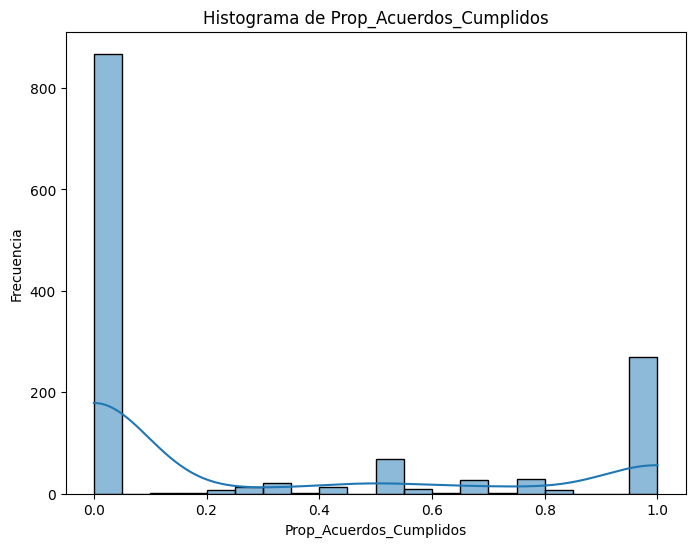

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(data=DF_solicitud_credito, x='Prop_Acuerdos_Cumplidos', bins=20, kde=True)
plt.title('Histograma de Prop_Acuerdos_Cumplidos')
plt.xlabel('Prop_Acuerdos_Cumplidos')
plt.ylabel('Frecuencia')
plt.show()


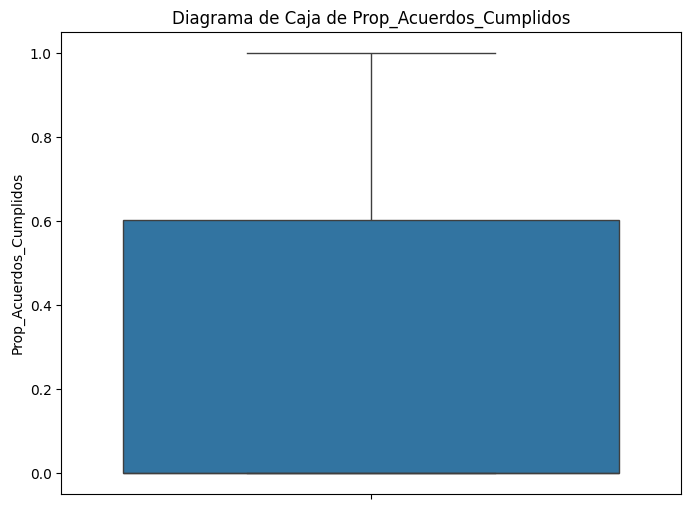

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=DF_solicitud_credito, y='Prop_Acuerdos_Cumplidos')
plt.title('Diagrama de Caja de Prop_Acuerdos_Cumplidos')
plt.ylabel('Prop_Acuerdos_Cumplidos')
plt.show()


In [9]:
quartiles = DF_solicitud_credito['Prop_Acuerdos_Cumplidos'].describe(percentiles=[0.25, 0.5, 0.75])

print(quartiles)


count    1340.000000
mean        0.279613
std         0.410253
min         0.000000
25%         0.000000
50%         0.000000
75%         0.603846
max         1.000000
Name: Prop_Acuerdos_Cumplidos, dtype: float64


Dada la proporción de los datos, se analiza que para poder darle un incentivo al cliente por cumplimiento de acuerdo, derá cumplir estrictamente el 100% de sus acuerdos, de lo contrario, no es un comportamiento adecuado en la empresa